In [24]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from torch import nn

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [25]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor()
)

print('Shape of image:', training_data[0][0].shape)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)



Shape of image: torch.Size([1, 28, 28])


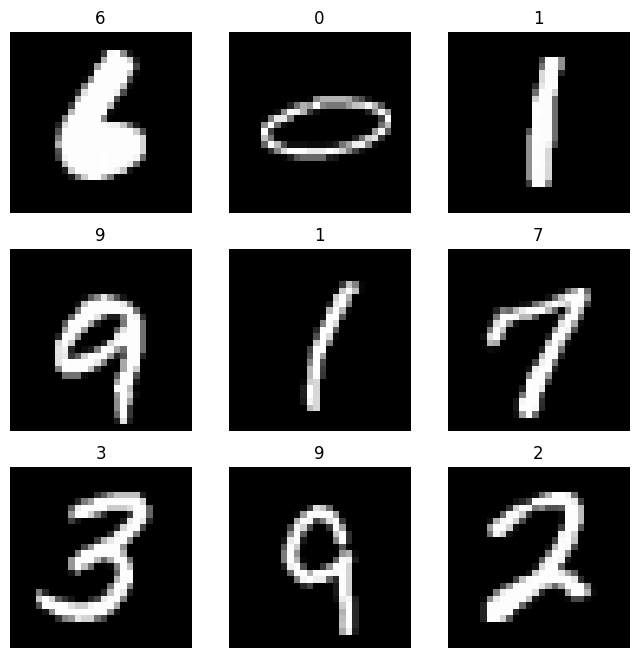

In [26]:
labels_map = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Build the Network #


In [27]:
# This would be stored in models.py 

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 10),
            nn.ReLU(),
            nn.Dropout(0.5),

        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 28*28),
            nn.Sigmoid()

        )

    def encode(self, x):
        x = self.flatten(x)
        z = self.encoder(x)
        return z
    
    def decode(self, z):
        logits = self.decoder(z)
        return logits
    
    def forward(self, x):
        z = self.encode(x)
        logits = self.decode(z)
        return logits

In [28]:
model = AutoEncoder().to(device)
print(model)

AutoEncoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=32, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=32, out_features=10, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7)

Text(0.5, 1.0, 'Model Output (untrained)')

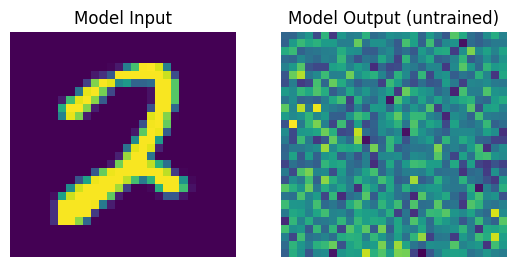

In [29]:
examp_img, examp_label =  training_data[sample_idx]


device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
examp_img_device = examp_img.to(device)
model = AutoEncoder().to(device)


examp_output = model(examp_img_device)
examp_output_cpu = examp_output.cpu().detach().numpy()

fig, ax = plt.subplots(1,2)
ax[0].imshow(np.squeeze(np.array(examp_img)))
ax[0].axis('off')
ax[0].set_title('Model Input')
ax[1].imshow(np.reshape(np.squeeze(np.array(examp_output_cpu)), (28,28)))
ax[1].axis('off')
ax[1].set_title('Model Output (untrained)')

# Train da model #


In [30]:
learning_rate = 5e-3
batch_size = 64
epochs = 5

loss = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
# Copied from the Pytorch Tutoria;l

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        # Compute prediction and loss
        # Move data to the device
        X = X.to(device)
        pred = model(X)
        loss = loss_fn(pred, X.view(-1,28*28))

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, _ in dataloader:
            # Move data to the device
            X = X.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, X.view(-1,28*28)).item()

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")


In [33]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 25
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")



Epoch 1
-------------------------------
loss: 0.224994  [   64/60000]
loss: 0.069517  [ 6464/60000]
loss: 0.060467  [12864/60000]
loss: 0.071088  [19264/60000]
loss: 0.064609  [25664/60000]
loss: 0.064068  [32064/60000]
loss: 0.060389  [38464/60000]
loss: 0.061076  [44864/60000]
loss: 0.072562  [51264/60000]
loss: 0.061963  [57664/60000]
Test Error: 
 Avg loss: 0.065168 

Epoch 2
-------------------------------
loss: 0.058745  [   64/60000]
loss: 0.064113  [ 6464/60000]
loss: 0.059246  [12864/60000]
loss: 0.070516  [19264/60000]
loss: 0.061761  [25664/60000]
loss: 0.063847  [32064/60000]
loss: 0.059709  [38464/60000]
loss: 0.059956  [44864/60000]
loss: 0.072638  [51264/60000]
loss: 0.062236  [57664/60000]
Test Error: 
 Avg loss: 0.061913 

Epoch 3
-------------------------------
loss: 0.062493  [   64/60000]
loss: 0.065093  [ 6464/60000]
loss: 0.060931  [12864/60000]
loss: 0.071112  [19264/60000]
loss: 0.061722  [25664/60000]
loss: 0.066280  [32064/60000]
loss: 0.061856  [38464/60000]


In [34]:
# Save the trained model
torch.save(model.state_dict(), 'autoencoder.pth')
print("Model saved as 'autoencoder.pth'")

Model saved as 'autoencoder.pth'


[[ 4.90447909e-01  4.90207404e-01  4.97530222e-01  5.03728688e-01
   4.83506501e-01  5.12176633e-01  4.79296863e-01  5.03731072e-01
   4.97074544e-01  4.98185694e-01  5.11299491e-01  4.92117912e-01
   4.94723648e-01  5.02009988e-01  5.00027061e-01  5.01712084e-01
   5.07091403e-01  4.90360409e-01  5.04969716e-01  4.96061921e-01
   4.87019509e-01  5.17481446e-01  5.08868039e-01  4.93126661e-01
   4.89154965e-01  5.01225531e-01  5.09856522e-01  4.98079985e-01
   4.89501476e-01  5.04900813e-01  5.13547361e-01  5.08641303e-01
   5.11377156e-01  5.05119503e-01  5.05148351e-01  4.97082323e-01
   4.97225076e-01  5.19640625e-01  4.93981898e-01  5.02036870e-01
   5.02086639e-01  4.95184839e-01  4.87042129e-01  5.15200496e-01
   5.06001055e-01  4.88578320e-01  5.14429688e-01  4.87795681e-01
   5.00142276e-01  5.02755702e-01  4.71170008e-01  4.92020547e-01
   4.88892913e-01  4.92495656e-01  4.95624900e-01  4.96104687e-01
   5.09822428e-01  5.13771534e-01  4.89426613e-01  4.93588120e-01
   4.94578

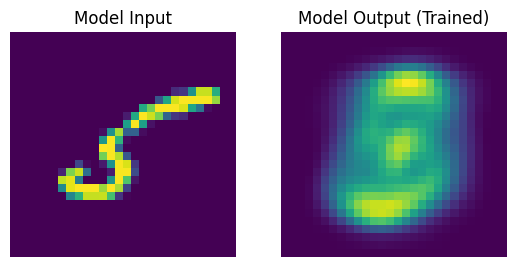

In [37]:
# Load the trained model and do inference
model = AutoEncoder()
model.load_state_dict(torch.load('autoencoder.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Load the example from before
examp_img, examp_label =  training_data[11] # I know it was in the training data


examp_output_ = model(examp_img_device)
examp_output_cpu_ = examp_output_.cpu().detach().numpy()
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.squeeze(np.array(examp_img)))
ax[0].axis('off')
ax[0].set_title('Model Input')
ax[1].imshow(np.reshape(np.squeeze(np.array(examp_output_cpu_)), (28,28)))
ax[1].axis('off')
ax[1].set_title('Model Output (Trained)')



print(examp_output_cpu - examp_output_cpu_)
